# Defect Classifications of AOI

In [1]:
!pip install --upgrade scipy
!pip install --upgrade scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 32.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.1
    Uninstalling scipy-1.11.1:
      Successfully uninstalled scipy-1.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.6.0 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
EPOCHS = 100

## Get file and score

In [4]:
def Drawloss(loss_list, val_loss_list):
    lens = len(loss_list)
    fig = plt.figure(figsize=(8, 5))
    fig.add_subplot(2,2,(1,4))
    plt.style.use("ggplot")

    plt.plot(range(1, lens+1), loss_list, label="train_loss")
    plt.plot(range(1, lens+1), val_loss_list, label="val_loss")

    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    plt.show()

In [5]:
def val_accuracy(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"{model_path}, Val Accuracy: {accuracy:.2f}%")

In [6]:
def test_result(model_path, csv_filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    predicted_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_list.append(predicted.item())
            
    test_df['Label'] = predicted_list
    test_df.to_csv(f'{csv_filename}', index=False)

## 1. Data preprocess

In [7]:
train_df = pd.read_csv('/kaggle/input/csv-index/train.csv')
test_df = pd.read_csv('/kaggle/input/csv-index/test.csv')

In [8]:
len(train_df)

2528

In [9]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = False):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "ID"]
        label = self.df.loc[index, "Label"].item()
        image = Image.open(os.path.join(self.images_folder, filename))
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=3)
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [11]:
dataset = CustomDataset('/kaggle/input/csv-index/train.csv','/kaggle/input/train-image-aoi/train_images', transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
test_dataset = CustomDataset('/kaggle/input/csv-index/test.csv','/kaggle/input/test-image-aoi/test_images', transform=test_transform)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [12]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32])


In [13]:
class EarlyStopper:
    def __init__(self, model_path, patience=30, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.model_path = model_path
        self.counter = 0
        self.min_val_loss = np.inf

    def check(self, val_loss, model):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
            torch.save(model, self.model_path)
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False 

## 2. PSPNet with deeper Model
> score：0.9802712
- extract feature based on Conv
- Use Pyramid Pooling, Onebyone Conv
- Append Upsampling
- Conv + Linear to classify
- all from scratch

In [ ]:
model_path = f'/kaggle/working/PSPNetDeeper_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/PSPNetDeeper_epoch{EPOCHS}_kaggle.csv'

In [ ]:
class PSPNet(nn.Module):
    def __init__(self, num_classes):
        super(PSPNet, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 16, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # output size (N, 64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 64, 64)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # output size (N, 128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 32, 32)
        )
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 128, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 128, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 128, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 128, 6, 6)
        self.con1 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.con2 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.con3 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.con4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=32/1, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample2 = nn.Upsample(scale_factor=32/2, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample3 = nn.Upsample(scale_factor=32/3, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample4 = nn.Upsample(scale_factor=32/6, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=132, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 8, 8)
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1), # output size (N, 32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 2, 2)
            nn.Flatten(), # output size (N, 32 * 2* 2)
            nn.Linear(32 * 2 * 2, 32), # output size (N, 32)
            nn.ReLU(),
            nn.Linear(32, num_classes), # output size (N, 6)
        )
        
    def forward(self, x):
        # CNN layers
        x = self.features(x)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.con1(x1) 
        x2 = self.pool2(x)
        x2 = self.con2(x2)
        x3 = self.pool3(x)
        x3 = self.con3(x3)
        x4 = self.pool4(x)
        x4 = self.con4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 132, 32, 32)
        
        # Classifier
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PSPNet(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

In [ ]:
Drawloss(loss_list, val_loss_list)

In [ ]:
# torch.save(model, model_path)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

## 2.5 PSPNet + GLCM features
> score：0.9815043
- extract feature based on Conv
- Use Pyramid Pooling, Onebyone Conv
- Append Upsampling
- Conv + Linear to classify
- Add a GLCM features
- all from scratch

In [14]:
model_path = f'/kaggle/working/PSPNetGLCM_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/PSPNetGLCM_epoch{EPOCHS}_kaggle.csv'

In [15]:
def GLCM_features(image):
    image = np.array(image)
    image = (image * 255).astype(np.uint8)
    glcm_features = torch.empty(25, dtype=torch.float32)

    #5 configuration for the grey-level co-occurrence matrix calculation
    dists = [[1],[3],[5],[3],[3],[3]]
    angles = [[0],[0],[0],[np.pi/4],[np.pi/2]]

    for j ,(dist, angle) in enumerate(zip(dists, angles)):
        GLCM = graycomatrix(image, dist, angle) 
        glcm_features[j*5] = torch.tensor(graycoprops(GLCM, 'energy')[0], dtype=torch.float32)
        glcm_features[j*5 + 1] = torch.tensor(graycoprops(GLCM, 'correlation')[0] , dtype=torch.float32)   
        glcm_features[j*5 + 2] = torch.tensor(graycoprops(GLCM, 'dissimilarity')[0], dtype=torch.float32)
        glcm_features[j*5 + 3] = torch.tensor(graycoprops(GLCM, 'homogeneity')[0], dtype=torch.float32)
        glcm_features[j*5 + 4] = torch.tensor(graycoprops(GLCM, 'contrast')[0], dtype=torch.float32)
        
    return glcm_features

In [16]:
class GLCMDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = False):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "ID"]
        label = self.df.loc[index, "Label"].item()
        image = Image.open(os.path.join(self.images_folder, filename))
        glcm_feature = GLCM_features(image)
        if self.transform:
            image = self.transform(image)
        return image, label, glcm_feature

In [17]:
dataset = GLCMDataset('/kaggle/input/csv-index/train.csv','/kaggle/input/train-image-aoi/train_images', transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
test_dataset = GLCMDataset('/kaggle/input/csv-index/test.csv','/kaggle/input/test-image-aoi/test_images', transform=test_transform)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [18]:
for images, labels, glcm_features in train_dataloader:
    print(images.shape)
    print(labels.shape)
    print(glcm_features.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32])
torch.Size([32, 25])


In [19]:
class PSPNetGLCM(nn.Module):
    def __init__(self, num_classes):
        super(PSPNetGLCM, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 16, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # output size (N, 64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 64, 64)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # output size (N, 128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 32, 32)
        )
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 128, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 128, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 128, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 128, 6, 6)
        self.con1 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.con2 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.con3 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.con4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=32/1, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample2 = nn.Upsample(scale_factor=32/2, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample3 = nn.Upsample(scale_factor=32/3, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample4 = nn.Upsample(scale_factor=32/6, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        
        # Conv Classifier layers
        self.nn_classifier = nn.Sequential(
            nn.Conv2d(in_channels=132, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 8, 8)
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1), # output size (N, 32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 2, 2)
            nn.Flatten(), # output size (N, 32 * 2* 2)
            nn.Linear(32 * 2 * 2, 24), # output size (N, 24)
            nn.ReLU(),
        )
        self.glcm_classifier= nn.Sequential(
            nn.Linear(25, 8), # output size (N, 8)
            nn.ReLU(),
        )
        self.final_classifier = nn.Sequential(
            nn.Linear(32, num_classes) # output size (N, num_classes=6)
        )
        
    def forward(self, x_input, x_glcm):
        # CNN layers
        x = self.features(x_input)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.con1(x1) 
        x2 = self.pool2(x)
        x2 = self.con2(x2)
        x3 = self.pool3(x)
        x3 = self.con3(x3)
        x4 = self.pool4(x)
        x4 = self.con4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 132, 32, 32)
        
        # Classifier
        x = self.nn_classifier(x) # output size (N, 24)
        
        # Get GLCM features 
        x_glcm = self.glcm_classifier(x_glcm) # output size (N, 8)
        
        # Concatenate nn features and GLCM features
        x = torch.cat((x, x_glcm), dim=1) # output size (N, 32, 32)
        
        # final classifier
        x = self.final_classifier(x)
        
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PSPNetGLCM(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels, glcm_features in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        glcm_features = glcm_features.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, glcm_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels, glcm_features in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            glcm_features = glcm_features.to(device)
            
            outputs = model(images, glcm_features)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

100%|██████████| 72/72 [01:51<00:00,  1.55s/it]


Epoch [1/100], Train Loss: 16.2546, Val Loss:6.9792


100%|██████████| 72/72 [01:20<00:00,  1.11s/it]


Epoch [2/100], Train Loss: 0.5808, Val Loss:1.6803


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


Epoch [3/100], Train Loss: 0.5775, Val Loss:1.1671


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


Epoch [4/100], Train Loss: 0.9668, Val Loss:0.9639


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


Epoch [5/100], Train Loss: 0.8884, Val Loss:0.7754


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


Epoch [6/100], Train Loss: 0.8017, Val Loss:0.7335


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


Epoch [7/100], Train Loss: 0.3841, Val Loss:0.5188


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


Epoch [8/100], Train Loss: 1.4022, Val Loss:0.5777


100%|██████████| 72/72 [01:22<00:00,  1.14s/it]


Epoch [9/100], Train Loss: 0.1283, Val Loss:0.4036


100%|██████████| 72/72 [01:21<00:00,  1.14s/it]


Epoch [10/100], Train Loss: 0.1874, Val Loss:0.3289


100%|██████████| 72/72 [01:20<00:00,  1.11s/it]


Epoch [11/100], Train Loss: 0.0597, Val Loss:0.2241


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


In [ ]:
def val_accuracy(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, glcm_features in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            glcm_features = glcm_features.to(device)
            
            outputs = model(images, glcm_features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"{model_path}, Val Accuracy: {accuracy:.2f}%")

In [ ]:
def test_result(model_path, csv_filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    predicted_list = []
    with torch.no_grad():
        for images, labels, glcm_features in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            glcm_features = glcm_features.to(device)
            
            outputs = model(images, glcm_features)
            _, predicted = torch.max(outputs.data, 1)
            predicted_list.append(predicted.item())
            
    test_df['Label'] = predicted_list
    test_df.to_csv(f'{csv_filename}', index=False)

In [ ]:
Drawloss(loss_list, val_loss_list)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

## 2.6 PSPNet + GLCM + LBP


In [25]:
model_path = f'/kaggle/working/PSPNetGLCMLBP_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/PSPNetGLCMLBP_epoch{EPOCHS}_kaggle.csv'

In [17]:
from skimage.feature import local_binary_pattern

def LBP_features(image):
    image = np.array(image)
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize
    return torch.tensor(lbp_hist, dtype=torch.float32)

In [18]:
class GLCM_LBPDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = False):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "ID"]
        label = self.df.loc[index, "Label"].item()
        image = Image.open(os.path.join(self.images_folder, filename))
        glcm_features = GLCM_features(image)
        lbp_features = LBP_features(image)
        tradi_features = torch.cat((glcm_features, lbp_features), dim=0)
        if self.transform:
            image = self.transform(image)
        return image, label, tradi_features

In [19]:
dataset = GLCM_LBPDataset('/kaggle/input/csv-index/train.csv','/kaggle/input/train-image-aoi/train_images', transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
test_dataset = GLCM_LBPDataset('/kaggle/input/csv-index/test.csv','/kaggle/input/test-image-aoi/test_images', transform=test_transform)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [20]:
for images, labels, tradi_feature in train_dataloader:
    print(images.shape)
    print(labels.shape)
    print(tradi_feature.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32])
torch.Size([32, 34])


In [21]:
class PSPNetGLCMLBP(nn.Module):
    def __init__(self, num_classes):
        super(PSPNetGLCMLBP, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 16, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # output size (N, 64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 64, 64)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # output size (N, 128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 32, 32)
        )
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 128, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 128, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 128, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 128, 6, 6)
        self.con1 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.con2 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.con3 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.con4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=32/1, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample2 = nn.Upsample(scale_factor=32/2, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample3 = nn.Upsample(scale_factor=32/3, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        self.upsample4 = nn.Upsample(scale_factor=32/6, mode='bilinear', align_corners=True) # output size (N, 1, 32, 32)
        
        # Conv Classifier layers
        self.nn_classifier = nn.Sequential(
            nn.Conv2d(in_channels=132, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 8, 8)
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1), # output size (N, 32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 2, 2)
            nn.Flatten(), # output size (N, 32 * 2* 2)
            nn.Linear(32 * 2 * 2, 24), # output size (N, 24)
            nn.ReLU(),
        )
        self.tradi_classifier= nn.Sequential(
            nn.Linear(34, 8), # output size (N, 8)
            nn.ReLU(),
        )
        self.fusion_classifier = nn.Sequential(
            nn.Linear(32, num_classes) # output size (N, num_classes=6)
        )
        
    def forward(self, x_input, x_tradi):
        # CNN layers
        x = self.features(x_input)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.con1(x1) 
        x2 = self.pool2(x)
        x2 = self.con2(x2)
        x3 = self.pool3(x)
        x3 = self.con3(x3)
        x4 = self.pool4(x)
        x4 = self.con4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 132, 32, 32)
        
        # Classifier
        x = self.nn_classifier(x) # output size (N, 24)
        
        # Get Traditional features (GLCM + LBP)
        x_tradi = self.tradi_classifier(x_tradi) # output size (N, 8)
         
        
        # Concatenate nn features and GLCM features
        x = torch.cat((x, x_tradi), dim=1) # output size (N, 32, 32)
        
        # fusion classifier
        x = self.fusion_classifier(x)
        
        return x

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PSPNetGLCMLBP(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels, tradi_features in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        tradi_features = tradi_features.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, tradi_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels, tradi_features in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            tradi_features = tradi_features.to(device)
            
            outputs = model(images, tradi_features)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

100%|██████████| 72/72 [03:07<00:00,  2.60s/it]


Epoch [1/100], Train Loss: 2.4581, Val Loss:1.5965


100%|██████████| 72/72 [02:49<00:00,  2.36s/it]


Epoch [2/100], Train Loss: 1.0808, Val Loss:1.3531


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [3/100], Train Loss: 0.6099, Val Loss:1.1825


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [4/100], Train Loss: 1.3145, Val Loss:1.0784


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [5/100], Train Loss: 1.3256, Val Loss:0.9682


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [6/100], Train Loss: 0.4441, Val Loss:0.7035


100%|██████████| 72/72 [02:45<00:00,  2.30s/it]


Epoch [7/100], Train Loss: 0.6004, Val Loss:0.5221


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [8/100], Train Loss: 0.7220, Val Loss:0.3258


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [9/100], Train Loss: 0.4104, Val Loss:0.2159


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [10/100], Train Loss: 0.0866, Val Loss:0.2997


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [11/100], Train Loss: 0.1198, Val Loss:0.4299


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [12/100], Train Loss: 0.0032, Val Loss:0.1353


100%|██████████| 72/72 [02:46<00:00,  2.31s/it]


Epoch [13/100], Train Loss: 0.0962, Val Loss:0.0892


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [14/100], Train Loss: 0.0092, Val Loss:0.0577


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [15/100], Train Loss: 0.0182, Val Loss:0.1373


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [16/100], Train Loss: 0.0053, Val Loss:0.0956


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [17/100], Train Loss: 0.0006, Val Loss:0.1101


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [18/100], Train Loss: 0.0081, Val Loss:0.0821


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [19/100], Train Loss: 0.0004, Val Loss:0.1064


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [20/100], Train Loss: 0.0629, Val Loss:0.0901


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [21/100], Train Loss: 0.0053, Val Loss:0.1260


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [22/100], Train Loss: 0.0261, Val Loss:0.0752


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [23/100], Train Loss: 0.0001, Val Loss:0.1374


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [24/100], Train Loss: 0.0184, Val Loss:0.1045


100%|██████████| 72/72 [02:45<00:00,  2.29s/it]


Epoch [25/100], Train Loss: 0.0075, Val Loss:0.0810


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [26/100], Train Loss: 0.0001, Val Loss:0.0707


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [27/100], Train Loss: 0.0083, Val Loss:0.0562


100%|██████████| 72/72 [02:45<00:00,  2.30s/it]


Epoch [28/100], Train Loss: 0.0013, Val Loss:0.2926


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [29/100], Train Loss: 0.0013, Val Loss:0.0615


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [30/100], Train Loss: 0.8269, Val Loss:0.1324


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [31/100], Train Loss: 0.0052, Val Loss:0.1058


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [32/100], Train Loss: 0.0067, Val Loss:0.0907


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [33/100], Train Loss: 0.0041, Val Loss:0.0510


100%|██████████| 72/72 [02:45<00:00,  2.29s/it]


Epoch [34/100], Train Loss: 0.0007, Val Loss:0.0618


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [35/100], Train Loss: 0.0533, Val Loss:0.0890


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [36/100], Train Loss: 0.0006, Val Loss:0.0593


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [37/100], Train Loss: 0.0048, Val Loss:0.1110


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [38/100], Train Loss: 0.0554, Val Loss:0.0911


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [39/100], Train Loss: 0.0293, Val Loss:0.0581


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [40/100], Train Loss: 0.0511, Val Loss:0.0658


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [41/100], Train Loss: 0.0151, Val Loss:0.0396


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [42/100], Train Loss: 0.0008, Val Loss:0.0258


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [43/100], Train Loss: 0.0005, Val Loss:0.0413


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [44/100], Train Loss: 0.0000, Val Loss:0.0487


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [45/100], Train Loss: 0.0064, Val Loss:0.0774


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [46/100], Train Loss: 0.0001, Val Loss:0.1361


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [47/100], Train Loss: 0.0001, Val Loss:0.0196


100%|██████████| 72/72 [02:45<00:00,  2.29s/it]


Epoch [48/100], Train Loss: 0.0066, Val Loss:0.0338


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [49/100], Train Loss: 0.0000, Val Loss:0.0679


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [50/100], Train Loss: 0.0037, Val Loss:0.1099


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [51/100], Train Loss: 0.0095, Val Loss:0.0623


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [52/100], Train Loss: 0.0043, Val Loss:0.0122


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [53/100], Train Loss: 0.0006, Val Loss:0.0156


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [54/100], Train Loss: 0.0016, Val Loss:0.1823


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [55/100], Train Loss: 0.0023, Val Loss:0.0133


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [56/100], Train Loss: 0.0045, Val Loss:0.0583


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [57/100], Train Loss: 0.0006, Val Loss:0.0166


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [58/100], Train Loss: 0.0150, Val Loss:0.0266


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [59/100], Train Loss: 0.0026, Val Loss:0.1169


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [60/100], Train Loss: 0.9322, Val Loss:0.0748


100%|██████████| 72/72 [02:46<00:00,  2.31s/it]


Epoch [61/100], Train Loss: 0.0838, Val Loss:0.1494


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [62/100], Train Loss: 1.1132, Val Loss:0.0613


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [63/100], Train Loss: 0.0058, Val Loss:0.0725


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [64/100], Train Loss: 0.0004, Val Loss:0.0358


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [65/100], Train Loss: 0.0007, Val Loss:0.1076


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [66/100], Train Loss: 0.2773, Val Loss:0.0980


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [67/100], Train Loss: 0.0060, Val Loss:0.0554


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [68/100], Train Loss: 0.0001, Val Loss:0.0596


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [69/100], Train Loss: 0.0093, Val Loss:0.0833


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [70/100], Train Loss: 0.0097, Val Loss:0.0953


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [71/100], Train Loss: 0.0155, Val Loss:0.0251


100%|██████████| 72/72 [02:45<00:00,  2.30s/it]


Epoch [72/100], Train Loss: 0.0145, Val Loss:0.0194


100%|██████████| 72/72 [02:47<00:00,  2.32s/it]


Epoch [73/100], Train Loss: 0.0000, Val Loss:0.0169


100%|██████████| 72/72 [02:46<00:00,  2.32s/it]


Epoch [74/100], Train Loss: 0.0007, Val Loss:0.0607


100%|██████████| 72/72 [02:47<00:00,  2.33s/it]


Epoch [75/100], Train Loss: 0.0003, Val Loss:0.1183


100%|██████████| 72/72 [02:46<00:00,  2.31s/it]


Epoch [76/100], Train Loss: 0.0003, Val Loss:0.0135


100%|██████████| 72/72 [02:47<00:00,  2.33s/it]


Epoch [77/100], Train Loss: 0.0059, Val Loss:0.0689


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [78/100], Train Loss: 1.0023, Val Loss:0.0697


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [79/100], Train Loss: 0.5028, Val Loss:0.0466


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [80/100], Train Loss: 0.0312, Val Loss:0.0771


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [81/100], Train Loss: 0.0020, Val Loss:0.0234


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [82/100], Train Loss: 0.0019, Val Loss:0.0119


100%|██████████| 72/72 [02:43<00:00,  2.28s/it]


Epoch [83/100], Train Loss: 0.0004, Val Loss:0.1224


100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


Epoch [84/100], Train Loss: 0.0001, Val Loss:0.0333


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [85/100], Train Loss: 0.0031, Val Loss:0.0594


100%|██████████| 72/72 [02:45<00:00,  2.30s/it]


Epoch [86/100], Train Loss: 0.0000, Val Loss:0.0278


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [87/100], Train Loss: 0.0006, Val Loss:0.0871


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [88/100], Train Loss: 0.0054, Val Loss:0.0173


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [89/100], Train Loss: 0.0000, Val Loss:0.0330


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [90/100], Train Loss: 0.0000, Val Loss:0.0236


100%|██████████| 72/72 [02:44<00:00,  2.28s/it]


Epoch [91/100], Train Loss: 0.0068, Val Loss:0.0375


100%|██████████| 72/72 [02:50<00:00,  2.37s/it]


Epoch [92/100], Train Loss: 0.0015, Val Loss:0.0546


100%|██████████| 72/72 [02:44<00:00,  2.29s/it]


Epoch [93/100], Train Loss: 0.0771, Val Loss:0.1377


100%|██████████| 72/72 [02:45<00:00,  2.29s/it]


Epoch [94/100], Train Loss: 0.0001, Val Loss:0.0877


100%|██████████| 72/72 [02:45<00:00,  2.30s/it]


Epoch [95/100], Train Loss: 0.0010, Val Loss:0.0429


100%|██████████| 72/72 [02:45<00:00,  2.30s/it]


Epoch [96/100], Train Loss: 0.0014, Val Loss:0.0211


100%|██████████| 72/72 [02:45<00:00,  2.30s/it]


Epoch [97/100], Train Loss: 0.0005, Val Loss:0.0355


100%|██████████| 72/72 [02:46<00:00,  2.31s/it]


Epoch [98/100], Train Loss: 0.0001, Val Loss:0.0518


100%|██████████| 72/72 [02:45<00:00,  2.29s/it]


Epoch [99/100], Train Loss: 0.0002, Val Loss:0.0578


100%|██████████| 72/72 [02:45<00:00,  2.30s/it]


Epoch [100/100], Train Loss: 0.0234, Val Loss:0.0183


In [24]:
def val_accuracy(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, tradi_features in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            tradi_features = tradi_features.to(device)
            
            outputs = model(images, tradi_features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"{model_path}, Val Accuracy: {accuracy:.2f}%")

In [25]:
def test_result(model_path, csv_filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    predicted_list = []
    with torch.no_grad():
        for images, labels, tradi_features in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            tradi_features = tradi_features.to(device)
            
            outputs = model(images, tradi_features)
            _, predicted = torch.max(outputs.data, 1)
            predicted_list.append(predicted.item())
            
    test_df['Label'] = predicted_list
    test_df.to_csv(f'{csv_filename}', index=False)

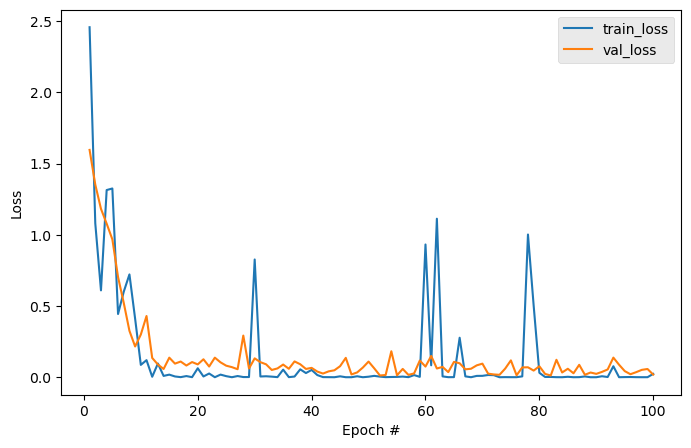

100%|██████████| 8/8 [00:18<00:00,  2.37s/it]


/kaggle/working/PSPNetGLCMLBP_epoch100_kaggle.pt, Val Accuracy: 99.21%


100%|██████████| 10142/10142 [13:52<00:00, 12.18it/s]


In [26]:
Drawloss(loss_list, val_loss_list)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

In [27]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(test_df, filename=predict_csv_path)

## 3. Baseline
> second best, In feature layer, channels number half is better. Half score(16->32):0.9528976,Full score(32->64):0.9418002
- extract feature based on Conv
- Linear to classify
- all from scratch

In [ ]:
model_path = f'/kaggle/working/BaseDeeper_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/BaseDeeper_epoch{EPOCHS}_kaggle.csv'

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 16, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # output size (N, 64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 64, 64)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # output size (N, 128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 32, 32)
        )
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 8, 8)
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1), # output size (N, 32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 2, 2)
            nn.Flatten(), # output size (N, 32 * 2* 2)
            nn.Linear(32 * 2 * 2, 32), # output size (N, 32)
            nn.ReLU(),
            nn.Linear(32, num_classes), # output size (N, 6)
        )
        
    def forward(self, x):
        # CNN layers
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

In [ ]:
Drawloss(loss_list, val_loss_list)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

## 4. ResNet 18
> The worst no need to submit
- first layer 3 channels change to 1 channel
- last append a new linear 
    - input size 1000 
    - output size class_num=6
- only train above 2 layers, other layer use pretrained ResNet18

In [ ]:
# # 檢視 ResNet18 模型結構
# net = models.resnet18()
# print(net)

In [ ]:
model_path = f'/kaggle/working/ResNet18_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/ResNet18_epoch{EPOCHS}_kaggle.pt'

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze the layers except the new conv1 and the classification layer
        for name, param in self.resnet.named_parameters():
            if 'conv1' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Modify the classification layer
        self.classifier = nn.Linear(self.resnet.fc.out_features, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
num_classes = 6
model = ResNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Define the optimizer for fine-tuning using Adam with a single learning rate
fine_tune_params = list(model.resnet.conv1.parameters()) + list(model.classifier.parameters())
optimizer = torch.optim.Adam(fine_tune_params, lr=0.001, betas=(0.9, 0.999))

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

In [ ]:
Drawloss(loss_list, val_loss_list)
val_accuracy(model_path)
test_result(model_path, predict_csv_path)

## 5. ResNet18 with PSPNet idea
> score: 0.9420468, worse then all from scratch
- first layer 3 channels change to 1 channel
- last append Pyramid Pooling layers, Onebyone Conv and Upsampling before ResNet18 layer4
- Conv + Linear to classify
- Train above 3 layers, other layer use pretrained ResNet18

In [ ]:
model_path = f'/kaggle/working/ResNetPSPNet_epoch{EPOCHS}_kaggle.pt'
predict_csv_path = f'/kaggle/working/ResNetPSPNet_epoch{EPOCHS}_kaggle.csv'

In [ ]:
class ResNetPSPNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNetPSPNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze the layers except the new conv1 and the classification layer
        for name, param in self.resnet.named_parameters():
            if 'conv1' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 512, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 512, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 512, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 512, 6, 6)
        self.onebyonecon1 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.onebyonecon2 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.onebyonecon3 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.onebyonecon4 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=16/1, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample2 = nn.Upsample(scale_factor=16/2, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample3 = nn.Upsample(scale_factor=16/3, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample4 = nn.Upsample(scale_factor=16/6, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=516, out_channels=128, kernel_size=3, stride=2, padding=1), # output size (N, 128, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 4, 4)
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 2, 2)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 1, 1)
            nn.Flatten(), # output size (N, 64 * 1 * 1)
            nn.Linear(64, num_classes), # output size (N, 6)
        )
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.onebyonecon1(x1) 
        x2 = self.pool2(x)
        x2 = self.onebyonecon2(x2)
        x3 = self.pool3(x)
        x3 = self.onebyonecon3(x3)
        x4 = self.pool4(x)
        x4 = self.onebyonecon4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 516, 16, 16)
        
        # Classifier
        x = self.classifier(x)
        
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
num_classes = 6
model = ResNetPSPNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# Define the optimizer for fine-tuning using Adam with a single learning rate

# Create a list of parameters to optimize (conv1 and classifier)
parameters_to_optimize = [
    {'params': model.resnet.conv1.parameters()},
    {'params': model.onebyonecon1.parameters()},
    {'params': model.onebyonecon2.parameters()},
    {'params': model.onebyonecon3.parameters()},
    {'params': model.onebyonecon4.parameters()},
    {'params': model.classifier.parameters()},
]
optimizer = torch.optim.Adam(parameters_to_optimize, lr=0.001, betas=(0.9, 0.999))

loss_list = []
val_loss_list = []
early_stopper = EarlyStopper(model_path = model_path)

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    
    
    model.eval()
    with torch.no_grad():
        tmp_loss_list = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            tmp_loss_list.append(val_loss.item())
        avg_val_loss = sum(tmp_loss_list)/len(tmp_loss_list)
        val_loss_list.append(avg_val_loss)
        if early_stopper.check(avg_val_loss, model):
            print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f},\nEarly stop in {epoch+1}!!')
            break
            
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss:{avg_val_loss:.4f}')

In [ ]:
Drawloss(loss_list, val_loss_list)

In [ ]:
val_accuracy(model_path)
test_result(model_path, predict_csv_path)